In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Original dataset exploration

This is the original dataset where the synthesized data for this competition was derived, from the following source:

Zhao, Xingang (2020), “Data for: On the prediction of critical heat flux using a physics-informed machine learning-aided framework”, Mendeley Data, V1, doi: 10.17632/5p5h37tyv7.1

We will explore this original dataset and look for correlations between features, to see if techniques such as regression can be used in the feature imputation exercise.

In [2]:
# Convert the CSV file to a Pandas DataFrame

data = pd.read_csv('original_data.csv', index_col=0)
data

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...
1861,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1862,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1863,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8


### What are the features?

- `author` - The original author of the research study
- `geometry` - The shape of the solid material being heated
- `pressure [MPa]` - The pressure at which the experiment was conducted (atmospheric pressure is 0.1013 kPa)
- `mass_flux [kg/m2-s]` - The rate of liquid mass flow
- `x_e_out [-]` - Outlet thermodynamic equilibrium ratio
- `D_e [mm]` - Effective diameter
- `D_h [mm]` - Hydraulic diameter
- `length [mm]` - Length of the solid material
- `chf_exp [MW/m2]` - Experimentally determined critical heat flux

In [3]:
# Rename the columns for simplicity

columns_map = {'pressure [MPa]': 'pressure',
               'mass_flux [kg/m2-s]': 'mass_flux',
               'x_e_out [-]': 'x_e_out',
               'D_e [mm]': 'D_e',
               'D_h [mm]': 'D_h',
               'length [mm]': 'length',
               'chf_exp [MW/m2]': 'chf_exp'}

data.rename(columns=columns_map, inplace=True)

In [4]:
# View the types of data in each column

data.dtypes

author        object
geometry      object
pressure     float64
mass_flux      int64
x_e_out      float64
D_e          float64
D_h          float64
length         int64
chf_exp      float64
dtype: object

In [5]:
# Count the NaN values in each column

data.isna().sum()

author       0
geometry     0
pressure     0
mass_flux    0
x_e_out      0
D_e          0
D_h          0
length       0
chf_exp      0
dtype: int64

First, we'll plot each numerical feature separately, to determine if there are any overall trends in the dataset.

<AxesSubplot:xlabel='id'>

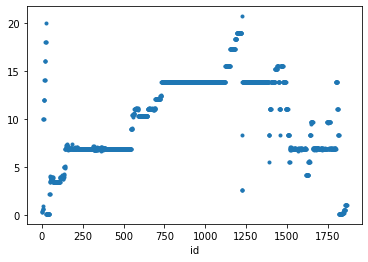

In [6]:
data['pressure'].plot(style='.')

<AxesSubplot:xlabel='id'>

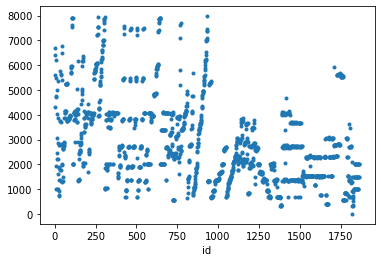

In [7]:
data['mass_flux'].plot(style='.')

<AxesSubplot:xlabel='id'>

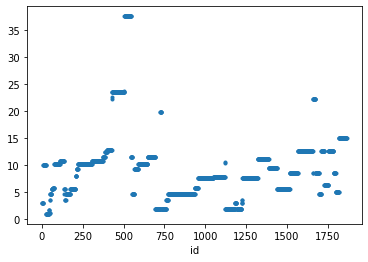

In [8]:
data['D_e'].plot(style='.')

<AxesSubplot:xlabel='id'>

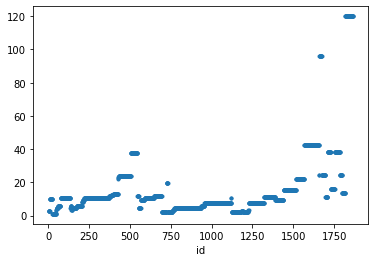

In [9]:
data['D_h'].plot(style='.')

<AxesSubplot:xlabel='id'>

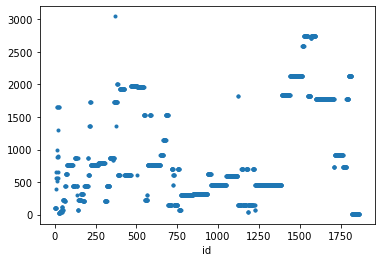

In [10]:
data['length'].plot(style='.')

<AxesSubplot:xlabel='id'>

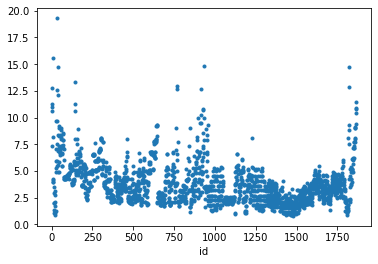

In [11]:
data['chf_exp'].plot(style='.')

<AxesSubplot:xlabel='id'>

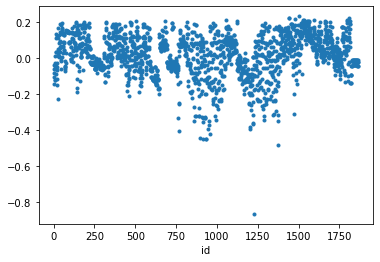

In [12]:
data['x_e_out'].plot(style='.')

The task here is to find correlations between column in the original dataset, so that these patterns can be used to fill in null values in the synthesized dataset.

Since there were no null values for the `chf_exp` column, we will start with this one, and try to find correlations with other columns.

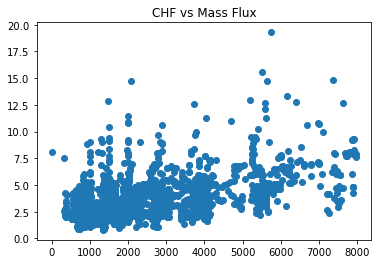

In [13]:
# Examining mass flux:

x = data['mass_flux']
y = data['chf_exp']
fig, ax = plt.subplots()

ax.set_title('CHF vs Mass Flux')
ax.scatter(x, y)

Doesn't look like much of a correlation. Let's try pressure next.

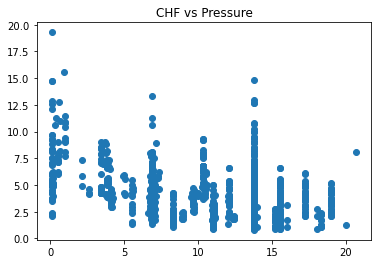

In [14]:
# Examining pressure:

x = data['pressure']
y = data['chf_exp']
fig, ax = plt.subplots()

ax.set_title('CHF vs Pressure')
ax.scatter(x, y)

This plot shows that recorded pressures mostly occurred in discrete values. But again, not a clear correlation. Let's explore length.

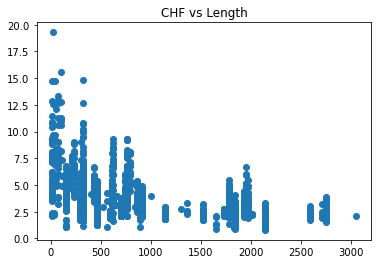

In [15]:
# Examining length:

x = data['length']
y = data['chf_exp']
fig, ax = plt.subplots()

ax.set_title('CHF vs Length')
ax.scatter(x, y)

There seems to be a correlation here - at shorter lengths, the CHF is greater. The function appears to resemble exponential decay.

In [ ]:
# Examining D_e:

x = data['D_e']
y = data['chf_exp']
fig, ax = plt.subplots()

ax.set_title('CHF vs D_e')
ax.scatter(x, y)

Again, discrete values, with CHF showing an inverse relationship.

In [ ]:
# Examining D_h:

x = data['D_h']
y = data['chf_exp']
fig, ax = plt.subplots()

ax.set_title('CHF vs D_h')
ax.scatter(x, y)

Again, discrete values with CHF showing an inverse relationship.

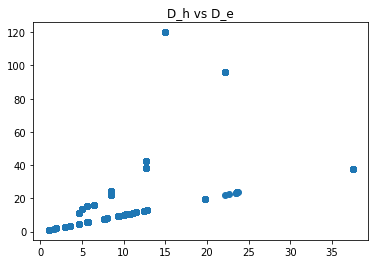

In [18]:
# Examining geometry:

x = data['D_e']
y = data['D_h']
fig, ax = plt.subplots()

ax.set_title('D_h vs D_e')
ax.scatter(x, y)

There's a roughly linear relationship between `D_h` and `D_e`, save for a few outliers. Let's find the equation of the least squares regression line:

In [19]:
# Remove outliers

diameters = data[['D_e', 'D_h']]
diameters = diameters.drop(diameters[diameters['D_h']>60].index)

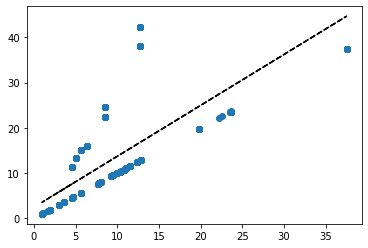

In [20]:
# Plot the LSR line

x = diameters['D_e']
y = diameters['D_h']
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, 'o', x, m*x+b, '--k')
plt.show()

In [21]:
# Print the values from the fitted LSR line

print(m)
print(b)

1.125005293061929
2.4657099242996416


This equation corresponds to the following relation:

`D_h = (m)*D_e + (b)`

Using this equation, if a value for either `D_h` or `D_e` is present in the synthetic dataset, then the other value can be predicted.

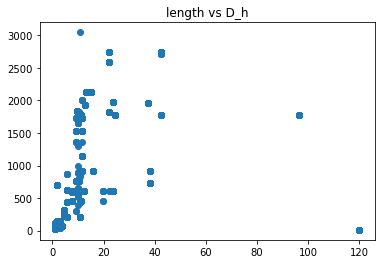

In [22]:
# Examining geometry:

x = data['D_h']
y = data['length']
fig, ax = plt.subplots()

ax.set_title('length vs D_h')
ax.scatter(x, y)

In [23]:
# Remove outliers

len_d = data[['D_h', 'length']]
len_d = len_d.drop(len_d[len_d['D_h']>60].index)

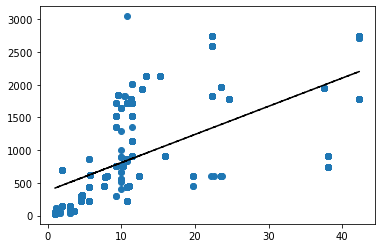

In [24]:
# Plot the LSR line

x = len_d['D_h']
y = len_d['length']
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, 'o', x, m*x+b, '--k')
plt.show()

In [25]:
# Print the values of the fitted LSR line

print(m)
print(b)

43.15466161101966
377.0360981911786


This isn't nearly as close of a correlation as with `D_h` and `D_e`. As such, it may be better to use another method to impute the missing values for the other features.